In [27]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict

In [38]:
# calculate du^ n / dt^n for arbitrary n and use this to create a loss term
def higher_order_loss_term(weight, outputs, t, norm_term, forcing_funct):
    
    # compute derivative of outputs with respect to inputs 
    deriv_to_t = torch.autograd.grad(outputs, t, grad_outputs=torch.ones_like(outputs), 
                                 create_graph=True)[0]
          
    # additional loss term
    loss_term = norm_term * weight * torch.mean((deriv_to_t + forcing_funct) ** 2)
    loss_term = weight * torch.mean((deriv_to_t + forcing_funct) ** 2)
    
    return loss_term, deriv_to_t

# build the loss function
def loss(t, As, lambda_vals, model, loss_term_weights):
            
    # create the trial solution
    u1_t = lambda t: model(t)[0][:, 0].unsqueeze(dim=1)
    u2_t = lambda t: model(t)[0][:, 1].unsqueeze(dim=1)
    
    # normalize loss and use it to compute the normalization factor
    norm_term1, norm_term2 = 1 / As[0] ** 2, 1 / As[1] ** 2
    
    # initialize all loss terms in case they do not need to be computed
    L_D, L_DD, L_DDD, L_DDDD = [torch.tensor([[0.]])] * 4
    
    # loss results
    loss_dict = {}
    
    # define f (aka forcing function) for each differential equation
    f1 = lambda t, u: lambda_vals[0] * u 
    f2 = lambda t, u: lambda_vals[1] * u 
    
    # compute u1(t) and u2(t)
    outputs1, outputs2 = u1_t(t), u2_t(t)
        
    # initial value loss terms
    initial_val_loss1 = (As[0] - u1_t(torch.tensor([[0]], dtype=torch.float32)))**2
    initial_val_loss2 = (As[1] - u2_t(torch.tensor([[0]], dtype=torch.float32)))**2
    initial_val_loss = initial_val_loss1 + initial_val_loss2

    # computes residual (function call also returns du / dt as u_t_x)
    L_D1, u_t_x1 = higher_order_loss_term(loss_term_weights[0], outputs1, t, norm_term1, f1(t, outputs2))
    L_D2, u_t_x2 = higher_order_loss_term(loss_term_weights[0], outputs2, t, norm_term2, f2(t, outputs1))
    L_D = L_D1 + L_D2     
    
    if loss_term_weights[1] or loss_term_weights[2] or loss_term_weights[3]:
        # define f' (derivative of f)
        f_t = lambda_val * u_t_x
        # first derivative of residual (function call also returns d^2u / dt^2 as u_tt_x)
        L_DD, u_tt_x = higher_order_loss_term(loss_term_weights[1], u_t_x, t, norm_term, f_t)

    if loss_term_weights[2] or loss_term_weights[3]:
        # define f'' (derivative of f')
        f_tt = lambda_val * u_tt_x
        # second derivative of residual (function call also returns d^3u / dt^3 as u_ttt_x)
        L_DDD, u_ttt_x = higher_order_loss_term(loss_term_weights[2], u_tt_x, t, norm_term, f_tt)
        
    if loss_term_weights[3]:
        # define f''' (derivative of f'')
        f_ttt = lambda_val * u_ttt_x
        # third derivative of residual (function call also returns d^4u / dt^4 as u_tttt_x)
        L_DDDD, u_tttt_x = higher_order_loss_term(loss_term_weights[3], u_ttt_x, t, norm_term, f_ttt)
        
    # total loss 
    L_total = L_D + L_DD + L_DDD + L_DDDD + initial_val_loss
        
    loss_dict['L_D'] = L_D
    loss_dict['L_DD'] = L_DD
    loss_dict['L_DDD'] = L_DDD
    loss_dict['L_DDDD'] = L_DDDD
    loss_dict['L_total'] = L_total

    return loss_dict


In [39]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size):
        super(BuildNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3)
        self.output = nn.Linear(h_size3, output_size) # bias = True
        
    def forward(self, x):
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result)
        h = self.tanh(result)
        result = self.output(h)
        
        return result, h

In [40]:
# train and evaluate the model
def run_model(iterations, min_x, max_x, A_vals, lambda_vals, loss_term_weights):
    
    assert sum(loss_term_weights) != 0, "ERROR: Invalid Loss Function"
    
    for idx, num in enumerate(loss_term_weights[:-1]):
        next_num = loss_term_weights[idx + 1]
        assert next_num <= num, 'ERROR: Invalid Loss Function'
      
    # build the neural net model
    model = BuildNetwork(1, 64, 64, 128, 2)
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    
    start_time = time.time()
    
    # starting initial value for transfer learning
    curr_A_indx = 0
    A = A_vals[curr_A_indx]
    print(f"Initial Conditions: {A}")
    # run the training loop
    for i in range(iterations):
        
        if i % 2000 == 0 and i != 0: 
            curr_A_indx += 1 
            A = A_vals[curr_A_indx]
            print(f"Initial Conditions: {A}")
        
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
        x = x[rng.integers(low=0, high=len(x), size=500)]
        x = x.reshape(-1, 1)

        # forward: compute loss
        curr_loss = loss(x, A, lambda_vals, model, loss_term_weights)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].item())
        loss_history['LDD_losses'].append(curr_loss['L_DD'].item())
        loss_history['LDDD_losses'].append(curr_loss['L_DDD'].item())
        loss_history['LDDDD_losses'].append(curr_loss['L_DDDD'].item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
#         scheduler.step()
        
        # compute the mse
        with torch.no_grad():
            e_term1, e_term2 = np.exp(-1.1 * x), np.exp(2.2 * x)
            true_sol1 = (0.5 * A[0] * e_term1 * (e_term2 + 1) - (0.5 * A[1] * e_term1 * (e_term2 - 1))).numpy()
            network_sol1 = model(x)[0][:, 0].unsqueeze(dim=1).numpy()
            true_sol2 = (0.5 * A[1] * e_term1 * (e_term2 + 1) - (0.5 * A[0] * e_term1 * (e_term2 - 1))).numpy()
            network_sol2 = model(x)[0][:, 1].unsqueeze(dim=1).numpy()
            
        current_mse = np.mean((true_sol1 - network_sol1) ** 2) + np.mean((true_sol2 - network_sol2) ** 2)
        MSEs.append(current_mse)
   
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

In [41]:
# function to plot the neural network vs exact solution
def plot_solution(min_x, max_x, As, lambda_vals, trained_model, axis):
    
    u1_t = lambda t: trained_model(t)[0][:, 0]
    u2_t = lambda t: trained_model(t)[0][:, 1]
    
    # plot the solution accuracies
    xx = np.linspace(min_x, max_x, 200)[:, None]

    with torch.no_grad():
        yy1 = u1_t(torch.Tensor(xx)).numpy()
        yy2 = u2_t(torch.Tensor(xx)).numpy()

    e_term1, e_term2 = np.exp(-1.1 * xx), np.exp(2.2 * xx)
    yt1 = (0.5 * As[0] * e_term1 * (e_term2 + 1) - (0.5 * As[1] * e_term1 * (e_term2 - 1)))
    yt2 = (0.5 * As[1] * e_term1 * (e_term2 + 1) - (0.5 * As[0] * e_term1 * (e_term2 - 1)))

    axis.plot(xx, yt1, label='Actual Solution $u_1(t)$')
    axis.plot(xx, yt2, label='Actual Solution $u_2(t)$')
    axis.plot(xx, yy1, '--', label='Neural Network Solution $u_1(t)$')
    axis.plot(xx, yy2, '--', label='Neural Network Solution $u_2(t)$')
    axis.set_title("u(t) vs t for Actual and Approximation")
    axis.set_xlabel('$t$')
    axis.set_ylabel('$u(t)$')
    axis.legend(loc='best')
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')
    
# function to plot the MSEs
def plot_mse(iterations, mses, axis):
    axis.plot(range(iterations), mses, label='MSE')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('MSE')
    axis.legend(loc='best')
    
# wrapper function to plot the solution and the overall loss of the network solution
def plot_loss_mse_and_solution(min_x, max_x, As, lambda_vals, iterations, 
                               trained_model, train_losses, loss_label, mses):
    fig, axs = plt.subplots(1, 3,  tight_layout=True, figsize=(24, 8))
    
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=axs[0], loss_label=loss_label)
    plot_solution(min_x=min_x, max_x=max_x, As=As, lambda_vals=lambda_vals, 
                  trained_model=trained_model, axis=axs[1])
    plot_mse(iterations=iterations, mses=mses, axis=axs[2])
    
    plt.show()
    
# function to plot the loss terms for a given model
def plot_individual_loss_terms(iterations, loss_dictionary):
    
    plt.figure(figsize=(9, 9))
    for label, losses in loss_dictionary.items():
        plt.plot(range(iterations), losses, label=label)
        
    plt.yscale("log")
    plt.title("Loss Terms vs Iterations")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [43]:
# set-up differential equation parameters for network
min_x, max_x = 0, 2
A_vals = [[0.75, 0.25], [0.75, 0.25], [0.75, 0.25], [0.75, 0.25], [0.75, 0.25]]
lambda_vals = [1.1, 1.1]
iterations = 10000

# run model which has a loss of the MSE (i.e. no higher order terms)
loss_history_w1, trained_model_w1, time_w1, MSE_w1 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                              lambda_vals=lambda_vals, loss_term_weights=[1, 0, 0, 0])

if False:
    
    # run model which has a loss of the residual and the first derivative of the residual (i.e. one higher order term)
    loss_history_w2, trained_model_w2, time_w2, MSE_w2 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                                    lambda_vals=lambda_vals, loss_term_weights=[1, 1, 0, 0])


    # run model which has a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
    loss_history_w3, trained_model_w3, time_w3, MSE_w3 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                                    lambda_vals=lambda_vals, loss_term_weights=[1, 1, 1, 0])

    # run model which has a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
    loss_history_w4, trained_model_w4, time_w4, MSE_w4 = run_model(iterations=iterations, min_x=min_x, max_x=max_x, A_vals=A_vals, 
                                                                    lambda_vals=lambda_vals, loss_term_weights=[1, 1, 1, 1])

Initial Conditions: [0.75, 0.25]
tensor([[0.7169]], grad_fn=<AddBackward0>)
tensor([[0.6898]], grad_fn=<AddBackward0>)
tensor([[0.6394]], grad_fn=<AddBackward0>)
tensor([[0.5761]], grad_fn=<AddBackward0>)
tensor([[0.5075]], grad_fn=<AddBackward0>)
tensor([[0.4409]], grad_fn=<AddBackward0>)
tensor([[0.3817]], grad_fn=<AddBackward0>)
tensor([[0.3328]], grad_fn=<AddBackward0>)
tensor([[0.2958]], grad_fn=<AddBackward0>)
tensor([[0.2704]], grad_fn=<AddBackward0>)
tensor([[0.2564]], grad_fn=<AddBackward0>)
tensor([[0.2458]], grad_fn=<AddBackward0>)
tensor([[0.2366]], grad_fn=<AddBackward0>)
tensor([[0.2318]], grad_fn=<AddBackward0>)
tensor([[0.2174]], grad_fn=<AddBackward0>)
tensor([[0.2135]], grad_fn=<AddBackward0>)
tensor([[0.1970]], grad_fn=<AddBackward0>)
tensor([[0.1768]], grad_fn=<AddBackward0>)
tensor([[0.1513]], grad_fn=<AddBackward0>)
tensor([[0.1376]], grad_fn=<AddBackward0>)
tensor([[0.1285]], grad_fn=<AddBackward0>)
tensor([[0.1198]], grad_fn=<AddBackward0>)
tensor([[0.1136]], gr

tensor([[0.0655]], grad_fn=<AddBackward0>)
tensor([[0.0657]], grad_fn=<AddBackward0>)
tensor([[0.0671]], grad_fn=<AddBackward0>)
tensor([[0.0684]], grad_fn=<AddBackward0>)
tensor([[0.0666]], grad_fn=<AddBackward0>)
tensor([[0.0685]], grad_fn=<AddBackward0>)
tensor([[0.0655]], grad_fn=<AddBackward0>)
tensor([[0.0668]], grad_fn=<AddBackward0>)
tensor([[0.0673]], grad_fn=<AddBackward0>)
tensor([[0.0671]], grad_fn=<AddBackward0>)
tensor([[0.0654]], grad_fn=<AddBackward0>)
tensor([[0.0659]], grad_fn=<AddBackward0>)
tensor([[0.0681]], grad_fn=<AddBackward0>)
tensor([[0.0672]], grad_fn=<AddBackward0>)
tensor([[0.0670]], grad_fn=<AddBackward0>)
tensor([[0.0662]], grad_fn=<AddBackward0>)
tensor([[0.0661]], grad_fn=<AddBackward0>)
tensor([[0.0658]], grad_fn=<AddBackward0>)
tensor([[0.0644]], grad_fn=<AddBackward0>)
tensor([[0.0672]], grad_fn=<AddBackward0>)
tensor([[0.0645]], grad_fn=<AddBackward0>)
tensor([[0.0664]], grad_fn=<AddBackward0>)
tensor([[0.0664]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0601]], grad_fn=<AddBackward0>)
tensor([[0.0611]], grad_fn=<AddBackward0>)
tensor([[0.0614]], grad_fn=<AddBackward0>)
tensor([[0.0621]], grad_fn=<AddBackward0>)
tensor([[0.0595]], grad_fn=<AddBackward0>)
tensor([[0.0605]], grad_fn=<AddBackward0>)
tensor([[0.0604]], grad_fn=<AddBackward0>)
tensor([[0.0605]], grad_fn=<AddBackward0>)
tensor([[0.0623]], grad_fn=<AddBackward0>)
tensor([[0.0618]], grad_fn=<AddBackward0>)
tensor([[0.0614]], grad_fn=<AddBackward0>)
tensor([[0.0619]], grad_fn=<AddBackward0>)
tensor([[0.0613]], grad_fn=<AddBackward0>)
tensor([[0.0604]], grad_fn=<AddBackward0>)
tensor([[0.0604]], grad_fn=<AddBackward0>)
tensor([[0.0610]], grad_fn=<AddBackward0>)
tensor([[0.0617]], grad_fn=<AddBackward0>)
tensor([[0.0610]], grad_fn=<AddBackward0>)
tensor([[0.0599]], grad_fn=<AddBackward0>)
tensor([[0.0601]], grad_fn=<AddBackward0>)
tensor([[0.0590]], grad_fn=<AddBackward0>)
tensor([[0.0587]], grad_fn=<AddBackward0>)
tensor([[0.0603]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0568]], grad_fn=<AddBackward0>)
tensor([[0.0600]], grad_fn=<AddBackward0>)
tensor([[0.0595]], grad_fn=<AddBackward0>)
tensor([[0.0575]], grad_fn=<AddBackward0>)
tensor([[0.0573]], grad_fn=<AddBackward0>)
tensor([[0.0605]], grad_fn=<AddBackward0>)
tensor([[0.0586]], grad_fn=<AddBackward0>)
tensor([[0.0594]], grad_fn=<AddBackward0>)
tensor([[0.0593]], grad_fn=<AddBackward0>)
tensor([[0.0586]], grad_fn=<AddBackward0>)
tensor([[0.0584]], grad_fn=<AddBackward0>)
tensor([[0.0576]], grad_fn=<AddBackward0>)
tensor([[0.0561]], grad_fn=<AddBackward0>)
tensor([[0.0586]], grad_fn=<AddBackward0>)
tensor([[0.0593]], grad_fn=<AddBackward0>)
tensor([[0.0571]], grad_fn=<AddBackward0>)
tensor([[0.0587]], grad_fn=<AddBackward0>)
tensor([[0.0592]], grad_fn=<AddBackward0>)
tensor([[0.0592]], grad_fn=<AddBackward0>)
tensor([[0.0560]], grad_fn=<AddBackward0>)
tensor([[0.0563]], grad_fn=<AddBackward0>)
tensor([[0.0578]], grad_fn=<AddBackward0>)
tensor([[0.0564]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0547]], grad_fn=<AddBackward0>)
tensor([[0.0540]], grad_fn=<AddBackward0>)
tensor([[0.0572]], grad_fn=<AddBackward0>)
tensor([[0.0549]], grad_fn=<AddBackward0>)
tensor([[0.0557]], grad_fn=<AddBackward0>)
tensor([[0.0557]], grad_fn=<AddBackward0>)
tensor([[0.0575]], grad_fn=<AddBackward0>)
tensor([[0.0549]], grad_fn=<AddBackward0>)
tensor([[0.0560]], grad_fn=<AddBackward0>)
tensor([[0.0559]], grad_fn=<AddBackward0>)
tensor([[0.0562]], grad_fn=<AddBackward0>)
tensor([[0.0561]], grad_fn=<AddBackward0>)
tensor([[0.0571]], grad_fn=<AddBackward0>)
tensor([[0.0584]], grad_fn=<AddBackward0>)
tensor([[0.0545]], grad_fn=<AddBackward0>)
tensor([[0.0542]], grad_fn=<AddBackward0>)
tensor([[0.0572]], grad_fn=<AddBackward0>)
tensor([[0.0551]], grad_fn=<AddBackward0>)
tensor([[0.0566]], grad_fn=<AddBackward0>)
tensor([[0.0560]], grad_fn=<AddBackward0>)
tensor([[0.0553]], grad_fn=<AddBackward0>)
tensor([[0.0570]], grad_fn=<AddBackward0>)
tensor([[0.0565]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0503]], grad_fn=<AddBackward0>)
tensor([[0.0550]], grad_fn=<AddBackward0>)
tensor([[0.0552]], grad_fn=<AddBackward0>)
tensor([[0.0520]], grad_fn=<AddBackward0>)
tensor([[0.0550]], grad_fn=<AddBackward0>)
tensor([[0.0525]], grad_fn=<AddBackward0>)
tensor([[0.0553]], grad_fn=<AddBackward0>)
tensor([[0.0548]], grad_fn=<AddBackward0>)
tensor([[0.0539]], grad_fn=<AddBackward0>)
tensor([[0.0540]], grad_fn=<AddBackward0>)
tensor([[0.0533]], grad_fn=<AddBackward0>)
tensor([[0.0534]], grad_fn=<AddBackward0>)
tensor([[0.0523]], grad_fn=<AddBackward0>)
tensor([[0.0535]], grad_fn=<AddBackward0>)
tensor([[0.0547]], grad_fn=<AddBackward0>)
tensor([[0.0524]], grad_fn=<AddBackward0>)
tensor([[0.0549]], grad_fn=<AddBackward0>)
tensor([[0.0546]], grad_fn=<AddBackward0>)
tensor([[0.0543]], grad_fn=<AddBackward0>)
tensor([[0.0529]], grad_fn=<AddBackward0>)
tensor([[0.0543]], grad_fn=<AddBackward0>)
tensor([[0.0553]], grad_fn=<AddBackward0>)
tensor([[0.0542]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0530]], grad_fn=<AddBackward0>)
tensor([[0.0522]], grad_fn=<AddBackward0>)
tensor([[0.0522]], grad_fn=<AddBackward0>)
tensor([[0.0526]], grad_fn=<AddBackward0>)
tensor([[0.0512]], grad_fn=<AddBackward0>)
tensor([[0.0516]], grad_fn=<AddBackward0>)
tensor([[0.0516]], grad_fn=<AddBackward0>)
tensor([[0.0551]], grad_fn=<AddBackward0>)
tensor([[0.0543]], grad_fn=<AddBackward0>)
tensor([[0.0532]], grad_fn=<AddBackward0>)
tensor([[0.0527]], grad_fn=<AddBackward0>)
tensor([[0.0514]], grad_fn=<AddBackward0>)
tensor([[0.0534]], grad_fn=<AddBackward0>)
tensor([[0.0517]], grad_fn=<AddBackward0>)
tensor([[0.0542]], grad_fn=<AddBackward0>)
tensor([[0.0485]], grad_fn=<AddBackward0>)
tensor([[0.0529]], grad_fn=<AddBackward0>)
tensor([[0.0502]], grad_fn=<AddBackward0>)
tensor([[0.0525]], grad_fn=<AddBackward0>)
tensor([[0.0526]], grad_fn=<AddBackward0>)
tensor([[0.0506]], grad_fn=<AddBackward0>)
tensor([[0.0540]], grad_fn=<AddBackward0>)
tensor([[0.0520]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0511]], grad_fn=<AddBackward0>)
tensor([[0.0524]], grad_fn=<AddBackward0>)
tensor([[0.0503]], grad_fn=<AddBackward0>)
tensor([[0.0488]], grad_fn=<AddBackward0>)
tensor([[0.0499]], grad_fn=<AddBackward0>)
tensor([[0.0497]], grad_fn=<AddBackward0>)
tensor([[0.0496]], grad_fn=<AddBackward0>)
tensor([[0.0511]], grad_fn=<AddBackward0>)
tensor([[0.0498]], grad_fn=<AddBackward0>)
tensor([[0.0494]], grad_fn=<AddBackward0>)
tensor([[0.0496]], grad_fn=<AddBackward0>)
tensor([[0.0517]], grad_fn=<AddBackward0>)
tensor([[0.0502]], grad_fn=<AddBackward0>)
tensor([[0.0499]], grad_fn=<AddBackward0>)
tensor([[0.0537]], grad_fn=<AddBackward0>)
tensor([[0.0485]], grad_fn=<AddBackward0>)
tensor([[0.0517]], grad_fn=<AddBackward0>)
tensor([[0.0505]], grad_fn=<AddBackward0>)
tensor([[0.0466]], grad_fn=<AddBackward0>)
tensor([[0.0482]], grad_fn=<AddBackward0>)
tensor([[0.0504]], grad_fn=<AddBackward0>)
tensor([[0.0513]], grad_fn=<AddBackward0>)
tensor([[0.0494]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0476]], grad_fn=<AddBackward0>)
tensor([[0.0462]], grad_fn=<AddBackward0>)
tensor([[0.0470]], grad_fn=<AddBackward0>)
tensor([[0.0496]], grad_fn=<AddBackward0>)
tensor([[0.0498]], grad_fn=<AddBackward0>)
tensor([[0.0480]], grad_fn=<AddBackward0>)
tensor([[0.0466]], grad_fn=<AddBackward0>)
tensor([[0.0486]], grad_fn=<AddBackward0>)
tensor([[0.0465]], grad_fn=<AddBackward0>)
tensor([[0.0477]], grad_fn=<AddBackward0>)
tensor([[0.0496]], grad_fn=<AddBackward0>)
tensor([[0.0484]], grad_fn=<AddBackward0>)
tensor([[0.0503]], grad_fn=<AddBackward0>)
tensor([[0.0470]], grad_fn=<AddBackward0>)
tensor([[0.0490]], grad_fn=<AddBackward0>)
tensor([[0.0475]], grad_fn=<AddBackward0>)
tensor([[0.0465]], grad_fn=<AddBackward0>)
tensor([[0.0487]], grad_fn=<AddBackward0>)
tensor([[0.0502]], grad_fn=<AddBackward0>)
tensor([[0.0484]], grad_fn=<AddBackward0>)
tensor([[0.0473]], grad_fn=<AddBackward0>)
tensor([[0.0480]], grad_fn=<AddBackward0>)
tensor([[0.0472]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0460]], grad_fn=<AddBackward0>)
tensor([[0.0469]], grad_fn=<AddBackward0>)
tensor([[0.0472]], grad_fn=<AddBackward0>)
tensor([[0.0461]], grad_fn=<AddBackward0>)
tensor([[0.0455]], grad_fn=<AddBackward0>)
tensor([[0.0470]], grad_fn=<AddBackward0>)
tensor([[0.0471]], grad_fn=<AddBackward0>)
tensor([[0.0457]], grad_fn=<AddBackward0>)
tensor([[0.0461]], grad_fn=<AddBackward0>)
tensor([[0.0491]], grad_fn=<AddBackward0>)
tensor([[0.0467]], grad_fn=<AddBackward0>)
tensor([[0.0475]], grad_fn=<AddBackward0>)
tensor([[0.0464]], grad_fn=<AddBackward0>)
tensor([[0.0474]], grad_fn=<AddBackward0>)
tensor([[0.0473]], grad_fn=<AddBackward0>)
tensor([[0.0473]], grad_fn=<AddBackward0>)
tensor([[0.0484]], grad_fn=<AddBackward0>)
tensor([[0.0485]], grad_fn=<AddBackward0>)
tensor([[0.0463]], grad_fn=<AddBackward0>)
tensor([[0.0463]], grad_fn=<AddBackward0>)
tensor([[0.0453]], grad_fn=<AddBackward0>)
tensor([[0.0473]], grad_fn=<AddBackward0>)
tensor([[0.0454]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0450]], grad_fn=<AddBackward0>)
tensor([[0.0453]], grad_fn=<AddBackward0>)
tensor([[0.0456]], grad_fn=<AddBackward0>)
tensor([[0.0449]], grad_fn=<AddBackward0>)
tensor([[0.0460]], grad_fn=<AddBackward0>)
tensor([[0.0458]], grad_fn=<AddBackward0>)
tensor([[0.0436]], grad_fn=<AddBackward0>)
tensor([[0.0434]], grad_fn=<AddBackward0>)
tensor([[0.0450]], grad_fn=<AddBackward0>)
tensor([[0.0462]], grad_fn=<AddBackward0>)
tensor([[0.0454]], grad_fn=<AddBackward0>)
tensor([[0.0461]], grad_fn=<AddBackward0>)
tensor([[0.0461]], grad_fn=<AddBackward0>)
tensor([[0.0440]], grad_fn=<AddBackward0>)
tensor([[0.0458]], grad_fn=<AddBackward0>)
tensor([[0.0453]], grad_fn=<AddBackward0>)
tensor([[0.0455]], grad_fn=<AddBackward0>)
tensor([[0.0435]], grad_fn=<AddBackward0>)
tensor([[0.0446]], grad_fn=<AddBackward0>)
tensor([[0.0432]], grad_fn=<AddBackward0>)
tensor([[0.0450]], grad_fn=<AddBackward0>)
tensor([[0.0462]], grad_fn=<AddBackward0>)
tensor([[0.0468]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0435]], grad_fn=<AddBackward0>)
tensor([[0.0413]], grad_fn=<AddBackward0>)
tensor([[0.0451]], grad_fn=<AddBackward0>)
tensor([[0.0427]], grad_fn=<AddBackward0>)
tensor([[0.0433]], grad_fn=<AddBackward0>)
tensor([[0.0428]], grad_fn=<AddBackward0>)
tensor([[0.0434]], grad_fn=<AddBackward0>)
tensor([[0.0455]], grad_fn=<AddBackward0>)
tensor([[0.0431]], grad_fn=<AddBackward0>)
tensor([[0.0442]], grad_fn=<AddBackward0>)
tensor([[0.0436]], grad_fn=<AddBackward0>)
tensor([[0.0436]], grad_fn=<AddBackward0>)
tensor([[0.0427]], grad_fn=<AddBackward0>)
tensor([[0.0431]], grad_fn=<AddBackward0>)
tensor([[0.0427]], grad_fn=<AddBackward0>)
tensor([[0.0441]], grad_fn=<AddBackward0>)
tensor([[0.0421]], grad_fn=<AddBackward0>)
tensor([[0.0444]], grad_fn=<AddBackward0>)
tensor([[0.0426]], grad_fn=<AddBackward0>)
tensor([[0.0412]], grad_fn=<AddBackward0>)
tensor([[0.0417]], grad_fn=<AddBackward0>)
tensor([[0.0422]], grad_fn=<AddBackward0>)
tensor([[0.0414]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0408]], grad_fn=<AddBackward0>)
tensor([[0.0404]], grad_fn=<AddBackward0>)
tensor([[0.0415]], grad_fn=<AddBackward0>)
tensor([[0.0394]], grad_fn=<AddBackward0>)
tensor([[0.0443]], grad_fn=<AddBackward0>)
tensor([[0.0382]], grad_fn=<AddBackward0>)
tensor([[0.0421]], grad_fn=<AddBackward0>)
tensor([[0.0395]], grad_fn=<AddBackward0>)
tensor([[0.0431]], grad_fn=<AddBackward0>)
tensor([[0.0403]], grad_fn=<AddBackward0>)
tensor([[0.0411]], grad_fn=<AddBackward0>)
tensor([[0.0427]], grad_fn=<AddBackward0>)
tensor([[0.0404]], grad_fn=<AddBackward0>)
tensor([[0.0404]], grad_fn=<AddBackward0>)
tensor([[0.0418]], grad_fn=<AddBackward0>)
tensor([[0.0413]], grad_fn=<AddBackward0>)
tensor([[0.0416]], grad_fn=<AddBackward0>)
tensor([[0.0414]], grad_fn=<AddBackward0>)
tensor([[0.0414]], grad_fn=<AddBackward0>)
tensor([[0.0416]], grad_fn=<AddBackward0>)
tensor([[0.0410]], grad_fn=<AddBackward0>)
tensor([[0.0402]], grad_fn=<AddBackward0>)
tensor([[0.0397]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0390]], grad_fn=<AddBackward0>)
tensor([[0.0382]], grad_fn=<AddBackward0>)
tensor([[0.0421]], grad_fn=<AddBackward0>)
tensor([[0.0390]], grad_fn=<AddBackward0>)
tensor([[0.0395]], grad_fn=<AddBackward0>)
tensor([[0.0386]], grad_fn=<AddBackward0>)
tensor([[0.0373]], grad_fn=<AddBackward0>)
tensor([[0.0386]], grad_fn=<AddBackward0>)
tensor([[0.0386]], grad_fn=<AddBackward0>)
tensor([[0.0368]], grad_fn=<AddBackward0>)
tensor([[0.0374]], grad_fn=<AddBackward0>)
tensor([[0.0390]], grad_fn=<AddBackward0>)
tensor([[0.0384]], grad_fn=<AddBackward0>)
tensor([[0.0376]], grad_fn=<AddBackward0>)
tensor([[0.0392]], grad_fn=<AddBackward0>)
tensor([[0.0381]], grad_fn=<AddBackward0>)
tensor([[0.0389]], grad_fn=<AddBackward0>)
tensor([[0.0398]], grad_fn=<AddBackward0>)
tensor([[0.0379]], grad_fn=<AddBackward0>)
tensor([[0.0388]], grad_fn=<AddBackward0>)
tensor([[0.0400]], grad_fn=<AddBackward0>)
tensor([[0.0406]], grad_fn=<AddBackward0>)
tensor([[0.0400]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0369]], grad_fn=<AddBackward0>)
tensor([[0.0367]], grad_fn=<AddBackward0>)
tensor([[0.0364]], grad_fn=<AddBackward0>)
tensor([[0.0367]], grad_fn=<AddBackward0>)
tensor([[0.0362]], grad_fn=<AddBackward0>)
tensor([[0.0370]], grad_fn=<AddBackward0>)
tensor([[0.0370]], grad_fn=<AddBackward0>)
tensor([[0.0368]], grad_fn=<AddBackward0>)
tensor([[0.0360]], grad_fn=<AddBackward0>)
tensor([[0.0377]], grad_fn=<AddBackward0>)
tensor([[0.0361]], grad_fn=<AddBackward0>)
tensor([[0.0379]], grad_fn=<AddBackward0>)
tensor([[0.0365]], grad_fn=<AddBackward0>)
tensor([[0.0379]], grad_fn=<AddBackward0>)
tensor([[0.0372]], grad_fn=<AddBackward0>)
tensor([[0.0361]], grad_fn=<AddBackward0>)
tensor([[0.0365]], grad_fn=<AddBackward0>)
tensor([[0.0387]], grad_fn=<AddBackward0>)
tensor([[0.0370]], grad_fn=<AddBackward0>)
tensor([[0.0363]], grad_fn=<AddBackward0>)
tensor([[0.0364]], grad_fn=<AddBackward0>)
tensor([[0.0371]], grad_fn=<AddBackward0>)
tensor([[0.0362]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0342]], grad_fn=<AddBackward0>)
tensor([[0.0354]], grad_fn=<AddBackward0>)
tensor([[0.0339]], grad_fn=<AddBackward0>)
tensor([[0.0334]], grad_fn=<AddBackward0>)
tensor([[0.0365]], grad_fn=<AddBackward0>)
tensor([[0.0347]], grad_fn=<AddBackward0>)
tensor([[0.0365]], grad_fn=<AddBackward0>)
tensor([[0.0362]], grad_fn=<AddBackward0>)
tensor([[0.0344]], grad_fn=<AddBackward0>)
tensor([[0.0352]], grad_fn=<AddBackward0>)
tensor([[0.0358]], grad_fn=<AddBackward0>)
tensor([[0.0362]], grad_fn=<AddBackward0>)
tensor([[0.0343]], grad_fn=<AddBackward0>)
tensor([[0.0354]], grad_fn=<AddBackward0>)
tensor([[0.0360]], grad_fn=<AddBackward0>)
tensor([[0.0351]], grad_fn=<AddBackward0>)
tensor([[0.0370]], grad_fn=<AddBackward0>)
tensor([[0.0349]], grad_fn=<AddBackward0>)
tensor([[0.0345]], grad_fn=<AddBackward0>)
tensor([[0.0342]], grad_fn=<AddBackward0>)
tensor([[0.0332]], grad_fn=<AddBackward0>)
tensor([[0.0346]], grad_fn=<AddBackward0>)
tensor([[0.0358]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0321]], grad_fn=<AddBackward0>)
tensor([[0.0327]], grad_fn=<AddBackward0>)
tensor([[0.0343]], grad_fn=<AddBackward0>)
tensor([[0.0344]], grad_fn=<AddBackward0>)
tensor([[0.0355]], grad_fn=<AddBackward0>)
tensor([[0.0329]], grad_fn=<AddBackward0>)
tensor([[0.0338]], grad_fn=<AddBackward0>)
tensor([[0.0326]], grad_fn=<AddBackward0>)
tensor([[0.0325]], grad_fn=<AddBackward0>)
tensor([[0.0326]], grad_fn=<AddBackward0>)
tensor([[0.0327]], grad_fn=<AddBackward0>)
tensor([[0.0344]], grad_fn=<AddBackward0>)
tensor([[0.0335]], grad_fn=<AddBackward0>)
tensor([[0.0323]], grad_fn=<AddBackward0>)
tensor([[0.0323]], grad_fn=<AddBackward0>)
tensor([[0.0325]], grad_fn=<AddBackward0>)
tensor([[0.0319]], grad_fn=<AddBackward0>)
tensor([[0.0337]], grad_fn=<AddBackward0>)
tensor([[0.0340]], grad_fn=<AddBackward0>)
tensor([[0.0338]], grad_fn=<AddBackward0>)
tensor([[0.0331]], grad_fn=<AddBackward0>)
tensor([[0.0331]], grad_fn=<AddBackward0>)
tensor([[0.0335]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0306]], grad_fn=<AddBackward0>)
tensor([[0.0311]], grad_fn=<AddBackward0>)
tensor([[0.0314]], grad_fn=<AddBackward0>)
tensor([[0.0301]], grad_fn=<AddBackward0>)
tensor([[0.0323]], grad_fn=<AddBackward0>)
tensor([[0.0309]], grad_fn=<AddBackward0>)
tensor([[0.0299]], grad_fn=<AddBackward0>)
tensor([[0.0307]], grad_fn=<AddBackward0>)
tensor([[0.0318]], grad_fn=<AddBackward0>)
tensor([[0.0315]], grad_fn=<AddBackward0>)
tensor([[0.0312]], grad_fn=<AddBackward0>)
tensor([[0.0323]], grad_fn=<AddBackward0>)
tensor([[0.0300]], grad_fn=<AddBackward0>)
tensor([[0.0304]], grad_fn=<AddBackward0>)
tensor([[0.0311]], grad_fn=<AddBackward0>)
tensor([[0.0319]], grad_fn=<AddBackward0>)
tensor([[0.0302]], grad_fn=<AddBackward0>)
tensor([[0.0318]], grad_fn=<AddBackward0>)
tensor([[0.0306]], grad_fn=<AddBackward0>)
tensor([[0.0310]], grad_fn=<AddBackward0>)
tensor([[0.0304]], grad_fn=<AddBackward0>)
tensor([[0.0308]], grad_fn=<AddBackward0>)
tensor([[0.0302]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0279]], grad_fn=<AddBackward0>)
tensor([[0.0284]], grad_fn=<AddBackward0>)
tensor([[0.0286]], grad_fn=<AddBackward0>)
tensor([[0.0307]], grad_fn=<AddBackward0>)
tensor([[0.0312]], grad_fn=<AddBackward0>)
tensor([[0.0296]], grad_fn=<AddBackward0>)
tensor([[0.0278]], grad_fn=<AddBackward0>)
tensor([[0.0266]], grad_fn=<AddBackward0>)
tensor([[0.0287]], grad_fn=<AddBackward0>)
tensor([[0.0306]], grad_fn=<AddBackward0>)
tensor([[0.0307]], grad_fn=<AddBackward0>)
tensor([[0.0293]], grad_fn=<AddBackward0>)
tensor([[0.0286]], grad_fn=<AddBackward0>)
tensor([[0.0313]], grad_fn=<AddBackward0>)
tensor([[0.0283]], grad_fn=<AddBackward0>)
tensor([[0.0297]], grad_fn=<AddBackward0>)
tensor([[0.0287]], grad_fn=<AddBackward0>)
tensor([[0.0300]], grad_fn=<AddBackward0>)
tensor([[0.0289]], grad_fn=<AddBackward0>)
tensor([[0.0287]], grad_fn=<AddBackward0>)
tensor([[0.0302]], grad_fn=<AddBackward0>)
tensor([[0.0291]], grad_fn=<AddBackward0>)
tensor([[0.0285]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0279]], grad_fn=<AddBackward0>)
tensor([[0.0283]], grad_fn=<AddBackward0>)
tensor([[0.0277]], grad_fn=<AddBackward0>)
tensor([[0.0275]], grad_fn=<AddBackward0>)
tensor([[0.0295]], grad_fn=<AddBackward0>)
tensor([[0.0270]], grad_fn=<AddBackward0>)
tensor([[0.0276]], grad_fn=<AddBackward0>)
tensor([[0.0270]], grad_fn=<AddBackward0>)
tensor([[0.0252]], grad_fn=<AddBackward0>)
tensor([[0.0279]], grad_fn=<AddBackward0>)
tensor([[0.0275]], grad_fn=<AddBackward0>)
tensor([[0.0261]], grad_fn=<AddBackward0>)
tensor([[0.0255]], grad_fn=<AddBackward0>)
tensor([[0.0253]], grad_fn=<AddBackward0>)
tensor([[0.0265]], grad_fn=<AddBackward0>)
tensor([[0.0271]], grad_fn=<AddBackward0>)
tensor([[0.0275]], grad_fn=<AddBackward0>)
tensor([[0.0260]], grad_fn=<AddBackward0>)
tensor([[0.0251]], grad_fn=<AddBackward0>)
tensor([[0.0275]], grad_fn=<AddBackward0>)
tensor([[0.0285]], grad_fn=<AddBackward0>)
tensor([[0.0262]], grad_fn=<AddBackward0>)
tensor([[0.0271]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0249]], grad_fn=<AddBackward0>)
tensor([[0.0236]], grad_fn=<AddBackward0>)
tensor([[0.0245]], grad_fn=<AddBackward0>)
tensor([[0.0246]], grad_fn=<AddBackward0>)
tensor([[0.0247]], grad_fn=<AddBackward0>)
tensor([[0.0256]], grad_fn=<AddBackward0>)
tensor([[0.0257]], grad_fn=<AddBackward0>)
tensor([[0.0242]], grad_fn=<AddBackward0>)
tensor([[0.0243]], grad_fn=<AddBackward0>)
tensor([[0.0258]], grad_fn=<AddBackward0>)
tensor([[0.0247]], grad_fn=<AddBackward0>)
tensor([[0.0244]], grad_fn=<AddBackward0>)
tensor([[0.0266]], grad_fn=<AddBackward0>)
tensor([[0.0253]], grad_fn=<AddBackward0>)
tensor([[0.0259]], grad_fn=<AddBackward0>)
tensor([[0.0271]], grad_fn=<AddBackward0>)
tensor([[0.0230]], grad_fn=<AddBackward0>)
tensor([[0.0239]], grad_fn=<AddBackward0>)
tensor([[0.0254]], grad_fn=<AddBackward0>)
tensor([[0.0249]], grad_fn=<AddBackward0>)
tensor([[0.0253]], grad_fn=<AddBackward0>)
tensor([[0.0250]], grad_fn=<AddBackward0>)
tensor([[0.0244]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0228]], grad_fn=<AddBackward0>)
tensor([[0.0219]], grad_fn=<AddBackward0>)
tensor([[0.0229]], grad_fn=<AddBackward0>)
tensor([[0.0234]], grad_fn=<AddBackward0>)
tensor([[0.0228]], grad_fn=<AddBackward0>)
tensor([[0.0215]], grad_fn=<AddBackward0>)
tensor([[0.0219]], grad_fn=<AddBackward0>)
tensor([[0.0215]], grad_fn=<AddBackward0>)
tensor([[0.0245]], grad_fn=<AddBackward0>)
tensor([[0.0218]], grad_fn=<AddBackward0>)
tensor([[0.0217]], grad_fn=<AddBackward0>)
tensor([[0.0225]], grad_fn=<AddBackward0>)
tensor([[0.0237]], grad_fn=<AddBackward0>)
tensor([[0.0216]], grad_fn=<AddBackward0>)
tensor([[0.0222]], grad_fn=<AddBackward0>)
tensor([[0.0208]], grad_fn=<AddBackward0>)
tensor([[0.0235]], grad_fn=<AddBackward0>)
tensor([[0.0232]], grad_fn=<AddBackward0>)
tensor([[0.0231]], grad_fn=<AddBackward0>)
tensor([[0.0234]], grad_fn=<AddBackward0>)
tensor([[0.0219]], grad_fn=<AddBackward0>)
tensor([[0.0228]], grad_fn=<AddBackward0>)
tensor([[0.0227]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0199]], grad_fn=<AddBackward0>)
tensor([[0.0206]], grad_fn=<AddBackward0>)
tensor([[0.0217]], grad_fn=<AddBackward0>)
tensor([[0.0195]], grad_fn=<AddBackward0>)
tensor([[0.0220]], grad_fn=<AddBackward0>)
tensor([[0.0208]], grad_fn=<AddBackward0>)
tensor([[0.0211]], grad_fn=<AddBackward0>)
tensor([[0.0217]], grad_fn=<AddBackward0>)
tensor([[0.0207]], grad_fn=<AddBackward0>)
tensor([[0.0198]], grad_fn=<AddBackward0>)
tensor([[0.0222]], grad_fn=<AddBackward0>)
tensor([[0.0207]], grad_fn=<AddBackward0>)
tensor([[0.0204]], grad_fn=<AddBackward0>)
tensor([[0.0212]], grad_fn=<AddBackward0>)
tensor([[0.0206]], grad_fn=<AddBackward0>)
tensor([[0.0194]], grad_fn=<AddBackward0>)
tensor([[0.0207]], grad_fn=<AddBackward0>)
tensor([[0.0217]], grad_fn=<AddBackward0>)
tensor([[0.0207]], grad_fn=<AddBackward0>)
tensor([[0.0197]], grad_fn=<AddBackward0>)
tensor([[0.0201]], grad_fn=<AddBackward0>)
tensor([[0.0215]], grad_fn=<AddBackward0>)
tensor([[0.0209]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0184]], grad_fn=<AddBackward0>)
tensor([[0.0180]], grad_fn=<AddBackward0>)
tensor([[0.0173]], grad_fn=<AddBackward0>)
tensor([[0.0196]], grad_fn=<AddBackward0>)
tensor([[0.0186]], grad_fn=<AddBackward0>)
tensor([[0.0177]], grad_fn=<AddBackward0>)
tensor([[0.0190]], grad_fn=<AddBackward0>)
tensor([[0.0195]], grad_fn=<AddBackward0>)
tensor([[0.0179]], grad_fn=<AddBackward0>)
tensor([[0.0172]], grad_fn=<AddBackward0>)
tensor([[0.0175]], grad_fn=<AddBackward0>)
tensor([[0.0185]], grad_fn=<AddBackward0>)
tensor([[0.0177]], grad_fn=<AddBackward0>)
tensor([[0.0175]], grad_fn=<AddBackward0>)
tensor([[0.0171]], grad_fn=<AddBackward0>)
tensor([[0.0180]], grad_fn=<AddBackward0>)
tensor([[0.0194]], grad_fn=<AddBackward0>)
tensor([[0.0190]], grad_fn=<AddBackward0>)
tensor([[0.0186]], grad_fn=<AddBackward0>)
tensor([[0.0183]], grad_fn=<AddBackward0>)
tensor([[0.0173]], grad_fn=<AddBackward0>)
tensor([[0.0185]], grad_fn=<AddBackward0>)
tensor([[0.0183]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0158]], grad_fn=<AddBackward0>)
tensor([[0.0157]], grad_fn=<AddBackward0>)
tensor([[0.0156]], grad_fn=<AddBackward0>)
tensor([[0.0169]], grad_fn=<AddBackward0>)
tensor([[0.0153]], grad_fn=<AddBackward0>)
tensor([[0.0167]], grad_fn=<AddBackward0>)
tensor([[0.0163]], grad_fn=<AddBackward0>)
tensor([[0.0160]], grad_fn=<AddBackward0>)
tensor([[0.0177]], grad_fn=<AddBackward0>)
tensor([[0.0172]], grad_fn=<AddBackward0>)
tensor([[0.0155]], grad_fn=<AddBackward0>)
tensor([[0.0154]], grad_fn=<AddBackward0>)
tensor([[0.0148]], grad_fn=<AddBackward0>)
tensor([[0.0158]], grad_fn=<AddBackward0>)
tensor([[0.0183]], grad_fn=<AddBackward0>)
tensor([[0.0155]], grad_fn=<AddBackward0>)
tensor([[0.0163]], grad_fn=<AddBackward0>)
tensor([[0.0168]], grad_fn=<AddBackward0>)
tensor([[0.0166]], grad_fn=<AddBackward0>)
tensor([[0.0153]], grad_fn=<AddBackward0>)
tensor([[0.0171]], grad_fn=<AddBackward0>)
tensor([[0.0152]], grad_fn=<AddBackward0>)
tensor([[0.0163]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0160]], grad_fn=<AddBackward0>)
tensor([[0.0138]], grad_fn=<AddBackward0>)
tensor([[0.0144]], grad_fn=<AddBackward0>)
tensor([[0.0135]], grad_fn=<AddBackward0>)
tensor([[0.0121]], grad_fn=<AddBackward0>)
tensor([[0.0148]], grad_fn=<AddBackward0>)
tensor([[0.0137]], grad_fn=<AddBackward0>)
tensor([[0.0140]], grad_fn=<AddBackward0>)
tensor([[0.0140]], grad_fn=<AddBackward0>)
tensor([[0.0141]], grad_fn=<AddBackward0>)
tensor([[0.0133]], grad_fn=<AddBackward0>)
tensor([[0.0135]], grad_fn=<AddBackward0>)
tensor([[0.0125]], grad_fn=<AddBackward0>)
tensor([[0.0130]], grad_fn=<AddBackward0>)
tensor([[0.0139]], grad_fn=<AddBackward0>)
tensor([[0.0137]], grad_fn=<AddBackward0>)
tensor([[0.0132]], grad_fn=<AddBackward0>)
tensor([[0.0145]], grad_fn=<AddBackward0>)
tensor([[0.0135]], grad_fn=<AddBackward0>)
tensor([[0.0146]], grad_fn=<AddBackward0>)
tensor([[0.0141]], grad_fn=<AddBackward0>)
tensor([[0.0149]], grad_fn=<AddBackward0>)
tensor([[0.0134]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0121]], grad_fn=<AddBackward0>)
tensor([[0.0122]], grad_fn=<AddBackward0>)
tensor([[0.0119]], grad_fn=<AddBackward0>)
tensor([[0.0114]], grad_fn=<AddBackward0>)
tensor([[0.0116]], grad_fn=<AddBackward0>)
tensor([[0.0114]], grad_fn=<AddBackward0>)
tensor([[0.0119]], grad_fn=<AddBackward0>)
tensor([[0.0132]], grad_fn=<AddBackward0>)
tensor([[0.0111]], grad_fn=<AddBackward0>)
tensor([[0.0134]], grad_fn=<AddBackward0>)
tensor([[0.0111]], grad_fn=<AddBackward0>)
tensor([[0.0120]], grad_fn=<AddBackward0>)
tensor([[0.0112]], grad_fn=<AddBackward0>)
tensor([[0.0117]], grad_fn=<AddBackward0>)
tensor([[0.0113]], grad_fn=<AddBackward0>)
tensor([[0.0128]], grad_fn=<AddBackward0>)
tensor([[0.0114]], grad_fn=<AddBackward0>)
tensor([[0.0119]], grad_fn=<AddBackward0>)
tensor([[0.0112]], grad_fn=<AddBackward0>)
tensor([[0.0129]], grad_fn=<AddBackward0>)
tensor([[0.0118]], grad_fn=<AddBackward0>)
tensor([[0.0113]], grad_fn=<AddBackward0>)
tensor([[0.0111]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0092]], grad_fn=<AddBackward0>)
tensor([[0.0104]], grad_fn=<AddBackward0>)
tensor([[0.0099]], grad_fn=<AddBackward0>)
tensor([[0.0105]], grad_fn=<AddBackward0>)
tensor([[0.0101]], grad_fn=<AddBackward0>)
tensor([[0.0090]], grad_fn=<AddBackward0>)
tensor([[0.0093]], grad_fn=<AddBackward0>)
tensor([[0.0095]], grad_fn=<AddBackward0>)
tensor([[0.0097]], grad_fn=<AddBackward0>)
tensor([[0.0097]], grad_fn=<AddBackward0>)
tensor([[0.0089]], grad_fn=<AddBackward0>)
tensor([[0.0091]], grad_fn=<AddBackward0>)
tensor([[0.0105]], grad_fn=<AddBackward0>)
tensor([[0.0096]], grad_fn=<AddBackward0>)
tensor([[0.0094]], grad_fn=<AddBackward0>)
tensor([[0.0097]], grad_fn=<AddBackward0>)
tensor([[0.0086]], grad_fn=<AddBackward0>)
tensor([[0.0097]], grad_fn=<AddBackward0>)
tensor([[0.0096]], grad_fn=<AddBackward0>)
tensor([[0.0097]], grad_fn=<AddBackward0>)
tensor([[0.0090]], grad_fn=<AddBackward0>)
tensor([[0.0097]], grad_fn=<AddBackward0>)
tensor([[0.0098]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0078]], grad_fn=<AddBackward0>)
tensor([[0.0080]], grad_fn=<AddBackward0>)
tensor([[0.0076]], grad_fn=<AddBackward0>)
tensor([[0.0078]], grad_fn=<AddBackward0>)
tensor([[0.0078]], grad_fn=<AddBackward0>)
tensor([[0.0071]], grad_fn=<AddBackward0>)
tensor([[0.0071]], grad_fn=<AddBackward0>)
tensor([[0.0081]], grad_fn=<AddBackward0>)
tensor([[0.0086]], grad_fn=<AddBackward0>)
tensor([[0.0075]], grad_fn=<AddBackward0>)
tensor([[0.0076]], grad_fn=<AddBackward0>)
tensor([[0.0069]], grad_fn=<AddBackward0>)
tensor([[0.0082]], grad_fn=<AddBackward0>)
tensor([[0.0078]], grad_fn=<AddBackward0>)
tensor([[0.0077]], grad_fn=<AddBackward0>)
tensor([[0.0075]], grad_fn=<AddBackward0>)
tensor([[0.0084]], grad_fn=<AddBackward0>)
tensor([[0.0074]], grad_fn=<AddBackward0>)
tensor([[0.0080]], grad_fn=<AddBackward0>)
tensor([[0.0079]], grad_fn=<AddBackward0>)
tensor([[0.0081]], grad_fn=<AddBackward0>)
tensor([[0.0078]], grad_fn=<AddBackward0>)
tensor([[0.0079]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0062]], grad_fn=<AddBackward0>)
tensor([[0.0056]], grad_fn=<AddBackward0>)
tensor([[0.0069]], grad_fn=<AddBackward0>)
tensor([[0.0062]], grad_fn=<AddBackward0>)
tensor([[0.0064]], grad_fn=<AddBackward0>)
tensor([[0.0069]], grad_fn=<AddBackward0>)
tensor([[0.0070]], grad_fn=<AddBackward0>)
tensor([[0.0064]], grad_fn=<AddBackward0>)
tensor([[0.0062]], grad_fn=<AddBackward0>)
tensor([[0.0063]], grad_fn=<AddBackward0>)
tensor([[0.0069]], grad_fn=<AddBackward0>)
tensor([[0.0064]], grad_fn=<AddBackward0>)
tensor([[0.0061]], grad_fn=<AddBackward0>)
tensor([[0.0065]], grad_fn=<AddBackward0>)
tensor([[0.0058]], grad_fn=<AddBackward0>)
tensor([[0.0057]], grad_fn=<AddBackward0>)
tensor([[0.0062]], grad_fn=<AddBackward0>)
tensor([[0.0059]], grad_fn=<AddBackward0>)
tensor([[0.0061]], grad_fn=<AddBackward0>)
tensor([[0.0063]], grad_fn=<AddBackward0>)
tensor([[0.0064]], grad_fn=<AddBackward0>)
tensor([[0.0069]], grad_fn=<AddBackward0>)
tensor([[0.0065]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0051]], grad_fn=<AddBackward0>)
tensor([[0.0051]], grad_fn=<AddBackward0>)
tensor([[0.0049]], grad_fn=<AddBackward0>)
tensor([[0.0049]], grad_fn=<AddBackward0>)
tensor([[0.0051]], grad_fn=<AddBackward0>)
tensor([[0.0052]], grad_fn=<AddBackward0>)
tensor([[0.0046]], grad_fn=<AddBackward0>)
tensor([[0.0052]], grad_fn=<AddBackward0>)
tensor([[0.0047]], grad_fn=<AddBackward0>)
tensor([[0.0050]], grad_fn=<AddBackward0>)
tensor([[0.0050]], grad_fn=<AddBackward0>)
tensor([[0.0050]], grad_fn=<AddBackward0>)
tensor([[0.0054]], grad_fn=<AddBackward0>)
tensor([[0.0055]], grad_fn=<AddBackward0>)
tensor([[0.0044]], grad_fn=<AddBackward0>)
tensor([[0.0049]], grad_fn=<AddBackward0>)
tensor([[0.0047]], grad_fn=<AddBackward0>)
tensor([[0.0053]], grad_fn=<AddBackward0>)
tensor([[0.0050]], grad_fn=<AddBackward0>)
tensor([[0.0049]], grad_fn=<AddBackward0>)
tensor([[0.0046]], grad_fn=<AddBackward0>)
tensor([[0.0049]], grad_fn=<AddBackward0>)
tensor([[0.0056]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0040]], grad_fn=<AddBackward0>)
tensor([[0.0044]], grad_fn=<AddBackward0>)
tensor([[0.0041]], grad_fn=<AddBackward0>)
tensor([[0.0039]], grad_fn=<AddBackward0>)
tensor([[0.0035]], grad_fn=<AddBackward0>)
tensor([[0.0038]], grad_fn=<AddBackward0>)
tensor([[0.0040]], grad_fn=<AddBackward0>)
tensor([[0.0043]], grad_fn=<AddBackward0>)
tensor([[0.0034]], grad_fn=<AddBackward0>)
tensor([[0.0045]], grad_fn=<AddBackward0>)
tensor([[0.0047]], grad_fn=<AddBackward0>)
tensor([[0.0044]], grad_fn=<AddBackward0>)
tensor([[0.0039]], grad_fn=<AddBackward0>)
tensor([[0.0039]], grad_fn=<AddBackward0>)
tensor([[0.0044]], grad_fn=<AddBackward0>)
tensor([[0.0040]], grad_fn=<AddBackward0>)
tensor([[0.0039]], grad_fn=<AddBackward0>)
tensor([[0.0040]], grad_fn=<AddBackward0>)
tensor([[0.0041]], grad_fn=<AddBackward0>)
tensor([[0.0039]], grad_fn=<AddBackward0>)
tensor([[0.0037]], grad_fn=<AddBackward0>)
tensor([[0.0036]], grad_fn=<AddBackward0>)
tensor([[0.0037]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0036]], grad_fn=<AddBackward0>)
tensor([[0.0031]], grad_fn=<AddBackward0>)
tensor([[0.0032]], grad_fn=<AddBackward0>)
tensor([[0.0030]], grad_fn=<AddBackward0>)
tensor([[0.0031]], grad_fn=<AddBackward0>)
tensor([[0.0030]], grad_fn=<AddBackward0>)
tensor([[0.0030]], grad_fn=<AddBackward0>)
tensor([[0.0030]], grad_fn=<AddBackward0>)
tensor([[0.0033]], grad_fn=<AddBackward0>)
tensor([[0.0028]], grad_fn=<AddBackward0>)
tensor([[0.0029]], grad_fn=<AddBackward0>)
tensor([[0.0033]], grad_fn=<AddBackward0>)
tensor([[0.0031]], grad_fn=<AddBackward0>)
tensor([[0.0030]], grad_fn=<AddBackward0>)
tensor([[0.0033]], grad_fn=<AddBackward0>)
tensor([[0.0035]], grad_fn=<AddBackward0>)
tensor([[0.0032]], grad_fn=<AddBackward0>)
tensor([[0.0029]], grad_fn=<AddBackward0>)
tensor([[0.0030]], grad_fn=<AddBackward0>)
tensor([[0.0034]], grad_fn=<AddBackward0>)
tensor([[0.0035]], grad_fn=<AddBackward0>)
tensor([[0.0029]], grad_fn=<AddBackward0>)
tensor([[0.0030]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0023]], grad_fn=<AddBackward0>)
tensor([[0.0024]], grad_fn=<AddBackward0>)
tensor([[0.0028]], grad_fn=<AddBackward0>)
tensor([[0.0022]], grad_fn=<AddBackward0>)
tensor([[0.0024]], grad_fn=<AddBackward0>)
tensor([[0.0025]], grad_fn=<AddBackward0>)
tensor([[0.0027]], grad_fn=<AddBackward0>)
tensor([[0.0024]], grad_fn=<AddBackward0>)
tensor([[0.0024]], grad_fn=<AddBackward0>)
tensor([[0.0022]], grad_fn=<AddBackward0>)
tensor([[0.0027]], grad_fn=<AddBackward0>)
tensor([[0.0029]], grad_fn=<AddBackward0>)
tensor([[0.0024]], grad_fn=<AddBackward0>)
tensor([[0.0026]], grad_fn=<AddBackward0>)
tensor([[0.0027]], grad_fn=<AddBackward0>)
tensor([[0.0021]], grad_fn=<AddBackward0>)
tensor([[0.0023]], grad_fn=<AddBackward0>)
tensor([[0.0022]], grad_fn=<AddBackward0>)
tensor([[0.0023]], grad_fn=<AddBackward0>)
tensor([[0.0027]], grad_fn=<AddBackward0>)
tensor([[0.0023]], grad_fn=<AddBackward0>)
tensor([[0.0023]], grad_fn=<AddBackward0>)
tensor([[0.0023]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0019]], grad_fn=<AddBackward0>)
tensor([[0.0017]], grad_fn=<AddBackward0>)
tensor([[0.0019]], grad_fn=<AddBackward0>)
tensor([[0.0016]], grad_fn=<AddBackward0>)
tensor([[0.0018]], grad_fn=<AddBackward0>)
tensor([[0.0017]], grad_fn=<AddBackward0>)
tensor([[0.0020]], grad_fn=<AddBackward0>)
tensor([[0.0017]], grad_fn=<AddBackward0>)
tensor([[0.0016]], grad_fn=<AddBackward0>)
tensor([[0.0019]], grad_fn=<AddBackward0>)
tensor([[0.0016]], grad_fn=<AddBackward0>)
tensor([[0.0015]], grad_fn=<AddBackward0>)
tensor([[0.0018]], grad_fn=<AddBackward0>)
tensor([[0.0020]], grad_fn=<AddBackward0>)
tensor([[0.0016]], grad_fn=<AddBackward0>)
tensor([[0.0019]], grad_fn=<AddBackward0>)
tensor([[0.0016]], grad_fn=<AddBackward0>)
tensor([[0.0016]], grad_fn=<AddBackward0>)
tensor([[0.0019]], grad_fn=<AddBackward0>)
tensor([[0.0017]], grad_fn=<AddBackward0>)
tensor([[0.0019]], grad_fn=<AddBackward0>)
tensor([[0.0019]], grad_fn=<AddBackward0>)
tensor([[0.0018]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0014]], grad_fn=<AddBackward0>)
tensor([[0.0015]], grad_fn=<AddBackward0>)
tensor([[0.0017]], grad_fn=<AddBackward0>)
tensor([[0.0014]], grad_fn=<AddBackward0>)
tensor([[0.0015]], grad_fn=<AddBackward0>)
tensor([[0.0015]], grad_fn=<AddBackward0>)
tensor([[0.0016]], grad_fn=<AddBackward0>)
tensor([[0.0013]], grad_fn=<AddBackward0>)
tensor([[0.0015]], grad_fn=<AddBackward0>)
tensor([[0.0014]], grad_fn=<AddBackward0>)
tensor([[0.0013]], grad_fn=<AddBackward0>)
tensor([[0.0014]], grad_fn=<AddBackward0>)
tensor([[0.0015]], grad_fn=<AddBackward0>)
tensor([[0.0014]], grad_fn=<AddBackward0>)
tensor([[0.0014]], grad_fn=<AddBackward0>)
tensor([[0.0013]], grad_fn=<AddBackward0>)
tensor([[0.0016]], grad_fn=<AddBackward0>)
tensor([[0.0014]], grad_fn=<AddBackward0>)
tensor([[0.0016]], grad_fn=<AddBackward0>)
tensor([[0.0015]], grad_fn=<AddBackward0>)
tensor([[0.0015]], grad_fn=<AddBackward0>)
tensor([[0.0014]], grad_fn=<AddBackward0>)
tensor([[0.0017]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0012]], grad_fn=<AddBackward0>)
tensor([[0.0011]], grad_fn=<AddBackward0>)
tensor([[0.0012]], grad_fn=<AddBackward0>)
tensor([[0.0012]], grad_fn=<AddBackward0>)
tensor([[0.0014]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0012]], grad_fn=<AddBackward0>)
tensor([[0.0011]], grad_fn=<AddBackward0>)
tensor([[0.0012]], grad_fn=<AddBackward0>)
tensor([[0.0012]], grad_fn=<AddBackward0>)
tensor([[0.0013]], grad_fn=<AddBackward0>)
tensor([[0.0013]], grad_fn=<AddBackward0>)
tensor([[0.0013]], grad_fn=<AddBackward0>)
tensor([[0.0011]], grad_fn=<AddBackward0>)
tensor([[0.0011]], grad_fn=<AddBackward0>)
tensor([[0.0009]], grad_fn=<AddBackward0>)
tensor([[0.0011]], grad_fn=<AddBackward0>)
tensor([[0.0014]], grad_fn=<AddBackward0>)
tensor([[0.0011]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0009]], grad_fn=<AddBackward0>)
tensor([[0.0012]], grad_fn=<AddBackward0>)
tensor([[0.0012]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0009]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0009]], grad_fn=<AddBackward0>)
tensor([[0.0009]], grad_fn=<AddBackward0>)
tensor([[0.0011]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0011]], grad_fn=<AddBackward0>)
tensor([[0.0012]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0009]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0010]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0009]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0008]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0007]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0006]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0005]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.

tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0004]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.0003]], grad_fn=<AddBackward0>)
tensor([[0.

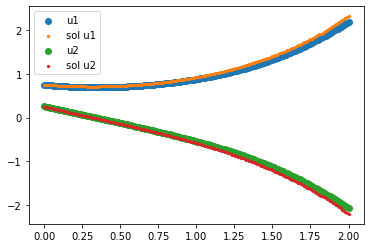

In [35]:
A = [0.75, 0.25]
xx = torch.Tensor(np.linspace(0, 2, 200)[:, None])
u_1 = trained_model_w1(xx)[0][:, 0].detach().numpy()
u_2 = trained_model_w1(xx)[0][:, 1].detach().numpy()

e_term1, e_term2 = np.exp(-1.1 * xx), np.exp(2.2 * xx)

yt1 = (0.5 * A[0] * e_term1 * (e_term2 + 1) - (0.5 * A[1] * e_term1 * (e_term2 - 1))).numpy()
yt2 = (0.5 * A[1] * e_term1 * (e_term2 + 1) - (0.5 * A[0] * e_term1 * (e_term2 - 1))).numpy()

plt.scatter(xx, u_1, label='u1')
plt.scatter(xx, yt1, label='sol u1', s=5)
plt.scatter(xx, u_2, label='u2')
plt.scatter(xx, yt2, label='sol u2', s=5)
plt.legend();


 Model 1: Loss = L_D


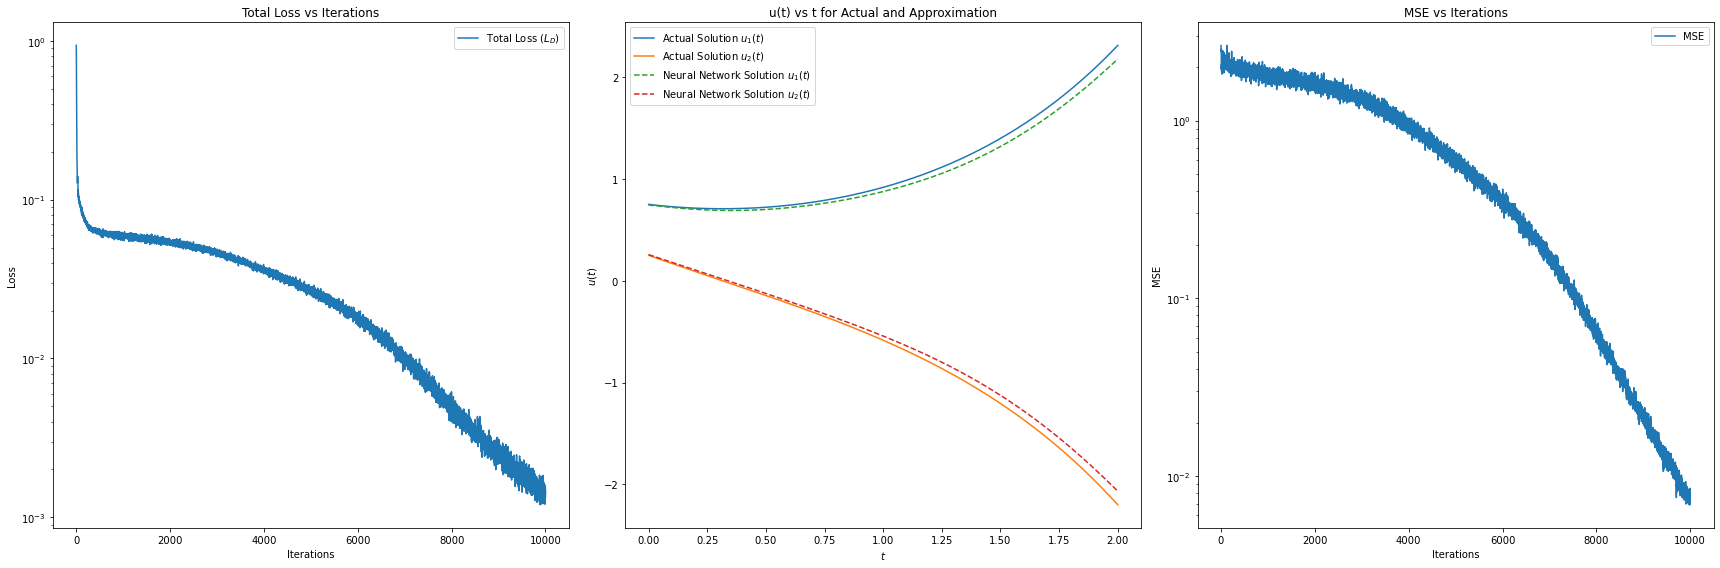

In [36]:
# plot overall loss and network solution for model which has a loss of the MSE (i.e. no higher order terms)
print("\n Model 1: Loss = L_D")
plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, As=A_vals[3], lambda_vals=lambda_vals, 
                       iterations=iterations, trained_model=trained_model_w1, 
                       train_losses=loss_history_w1['Ltotal_losses'], 
                       loss_label='Total Loss ($L_D$)', mses=MSE_w1)

if False:
    
    # plot overall loss and network solution for model which has a loss of the residual and the first derivative of the residual (i.e. one higher order term)
    print("\n Model 2: Loss = L_D + L_DD")
    plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                           iterations=iterations, trained_model=trained_model_w2, 
                           train_losses=loss_history_w2['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D + L_{DD}$)', mses=MSE_w2)


    # plot overall loss and network solution for model which has a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
    print("\n Model 3: Loss = L_D + L_DD + L_DDD")
    plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                           iterations=iterations, trained_model=trained_model_w3, 
                           train_losses=loss_history_w3['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D + L_{DD} + L_{DDD}$)', mses=MSE_w3)

    # plot overall loss and network solution for model which has a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
    print("\n Model 4: Loss = L_D + L_DD + L_DDD + L_DDDD")
    plot_loss_mse_and_solution(min_x=min_x, max_x=max_x, A=A_vals[3], lambda_val=lambda_val, 
                           iterations=iterations, trained_model=trained_model_w4, 
                           train_losses=loss_history_w4['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D + L_{DD} + L_{DDD} + L_{DDDD}$)', mses=MSE_w4)

In [37]:
if False:
    
    # plot of differential equation residual (L_D) for each updated model
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D$)' : loss_history_w1['LD_losses'],
                                            '$L_D$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LD_losses'],
                                            '$L_D$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LD_losses'],
                                            '$L_D$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LD_losses']})

    # plot of L_D and L_DD when using a loss of the residual and the first derivative of the residual (i.e. one higher order term)
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LD_losses'], 
                                            '$L_{DD}$ (loss = $L_D + L_{DD}$)' : loss_history_w2['LDD_losses']})

    # plot of L_D, L_DD, and L_DDD when using a loss of the residual and the first two derivatives of the residual (i.e. two higher order terms)
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LD_losses'], 
                                            '$L_{DD}$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LDD_losses'],
                                            '$L_{DDD}$ (loss = $L_D + L_{DD} + L_{DDD}$)' : loss_history_w3['LDDD_losses']})

    # plot of L_D, L_DD, L_DDD, and L_DDDD when using a loss of the residual and the first three derivatives of the residual (i.e. three higher order terms)
    plot_individual_loss_terms(iterations, {'$L_D$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LD_losses'], 
                                            '$L_{DD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDD_losses'],
                                            '$L_{DDD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDDD_losses'],
                                            '$L_{DDDD}$ (loss = $L_D + L_{DD} + L_{DDD} + L_{DDDD}$)' : loss_history_w4['LDDDD_losses']})


In [ ]:
# # create a t to take derivative with respect to 
# rng = np.random.default_rng()
# t_eval = torch.arange(0, 2, 0.001, requires_grad=True)
# t_eval = t_eval[rng.integers(low=0, high=2000, size=500)]
# t_eval = t_eval.reshape(-1, 1)

# # forward pass to extract H 
# output, H = trained_model_w1(t_eval) 

# print("H shape before column of 1s: ", H.shape)
# H = torch.cat((torch.ones(len(t_eval), 1), H), 1)
# print("H shape after column of 1s: ", H.shape)

# # compute derivative w/r/t H and multiply it by its transpose
# dH_dt = torch.autograd.functional.jacobian(trained_model_w1 ,t_eval, create_graph=True)[1].sum(axis=2)

# print("dh_dt before adjusting: ", dH_dt.shape)
# dH_dt = torch.cat((torch.zeros(len(t_eval), 1, 1), dH_dt), 1)
# print("dh_dt after adjusting: ", dH_dt.shape)

In [ ]:
# # compute dH_dt times dH_dt transpose 
# dH_dt_times_dH_dt_T = torch.matmul(dH_dt, dH_dt.mT)
# print("dH_dt * dH_dt_T: ", dH_dt_times_dH_dt_T.shape)

# # compute dH_dt times H transpose 
# new_H = torch.unsqueeze(H, dim=-1)
# dH_dt_times_H_T = torch.matmul(dH_dt, new_H.mT)
# print("dH_dt * H_T: ", dH_dt_times_H_T.shape)

# # compute H times dH_dt transpose
# H_times_dH_dt_T = torch.matmul(new_H, dH_dt.mT)

# # compute H times H transpose
# H_times_H_T = torch.matmul(new_H, new_H.mT)
# print("H * H_T: ", H_times_H_T.shape)

# # compute the sum of matrices across time
# # w_sum_term = dH_dt_times_dH_dt_T + 2 * lambda_val * dH_dt_times_H_T + lambda_val ** 2 * H_times_H_T
# w_sum_term = dH_dt_times_dH_dt_T + lambda_val * dH_dt_times_H_T + lambda_val * H_times_dH_dt_T + lambda_val ** 2 * H_times_H_T 

# print("W_sum shape before summing across time: ", w_sum_term.shape)
# w_sum_term = w_sum_term.sum(axis=0)
# w_sum_term = w_sum_term / len(t_eval)
# print("W_sum shape after summing across time: ", w_sum_term.shape)

# # compute H_0 and multiply it by its transpose 
# output_0, H_0 = trained_model_w1(torch.tensor([[0.]], dtype=torch.float32, requires_grad=True))
# print("H_0 shape before appending 1: ", H_0.shape)
# H_0 = torch.cat((torch.ones(1, 1), H_0), 1)
# print("H_0 shape after appending 1: ", H_0.shape)

# H_0_T_times_H_0 = torch.matmul(H_0.T, H_0)
# print("H_0_T * H_0 shape: ", H_0_T_times_H_0.shape)

In [ ]:
# # build the M matrix and find its inverse 
# M = w_sum_term + H_0_T_times_H_0
# M_inverse = torch.linalg.pinv(M)

# # compute W_out
# w_out = torch.matmul(M_inverse, H_0.T) * 0.75

In [ ]:
# tranfer_learned = [torch.matmul(w_out.T, new_H[i]).item() for i in range(500)]
# times = list(t_eval.detach().numpy().squeeze())

# true = [0.75 * np.exp(-lambda_val * time) for time in times]
# plt.scatter(times, tranfer_learned, label = 'Transfer Learning')
# plt.scatter(times, true, label='Analytical', s=10)
# plt.xlabel("t")
# plt.ylabel('y')
# plt.title("Transfer Learning vs Analytical Solution")
# plt.legend();

In [ ]:
# start_one_shot_time = time.time()
# rng = np.random.default_rng(12345)
# for i in range(10000):
#     random_u_0 = rng.random()
#     w_out = torch.matmul(M_inverse, H_0.T) * random_u_0
    
# end_one_shot_time = time.time() 
# total_one_shot = end_one_shot_time - start_one_shot_time
# print(f"Total Time to evaluate w_out for 10000 different initial conditions: {total_one_shot: .2f} seconds")

In [ ]:
# TODO:

# 1. make code work with 2 linear ODEs

# 2. make the code generalize to a system of n ODEs

# 3. compute the individual terms needed in the w_out calculation for a system

# 4. see how formula works and what can be changed while still doing it in "one shot"

# 5. Are the higher order terms, L_D and L_DD, etc.. still relevant?

# 6. see which parts of the formula are dependent on time and ask Pavlos how that works
    # (changing W_o means that only u_o will change eventually?)

# 7. try using a different diff. equation

# 9. make loss function proper


In [ ]:
# residuals = (torch.matmul(w_out.T, dH_dt[:]) + lambda_val * torch.matmul(w_out.T, new_H[:])) ** 2
# residuals = residuals.reshape(500, 1).detach().numpy()

# print(f"Mean of residuals: {residuals.mean()}")
# initial_cond_residuals = (torch.matmul(w_out.T, H_0.T) - 0.75) ** 2
# print(f"Initial Condition Residual: {initial_cond_residuals.item()}")

# plt.plot(residuals);
# plt.xlabel("t")
# plt.ylabel("Residual")
# plt.title("Plot of Residuals");

In [ ]:
# print(f"Difference Between Analytical and Tranfer Learned for t ={times[0]: .3f}: {(0.75 * np.exp(-lambda_val * times[0]) - torch.matmul(w_out.T, H[0])).item(): .5f}")
# print(f"Difference Between Analytical and Tranfer Learned for t ={times[100]: .3f}: {(0.75 * np.exp(-lambda_val * times[100]) - torch.matmul(w_out.T, H[100])).item(): .5f}")
# print(f"Difference Between Analytical and Tranfer Learned for t ={times[200]: .3f}: {(0.75 * np.exp(-lambda_val * times[200]) - torch.matmul(w_out.T, H[200])).item(): .5f}")

In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# H_test = H.detach()
# gm_H = torch.matmul(H_test.T, H_test)
# pca = PCA(n_components=5)
# pca.fit(gm_H)
# print(pca.explained_variance_ratio_)

# Appendix

### Notes:

- $u_t = lambda$ $t: A + t * model(t)$ is outdated, so we use $ u_t = lambda$ $t: A + (1 - exp(-t)) * model(t)$

- We are solving $\frac{du}{dt} + \lambda * u = 0$ where $f = -\lambda * u$

- Old Model Code: model = nn.Sequential(nn.Linear(1, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64,1))

- Old solution parametrization: u_t = lambda t: A + (1 - torch.exp(-t)) * model(t)

- Original normalization term: norm_term = 1 / u_t(torch.tensor([[0]], dtype=torch.float32)) ** 2